**READINGS / PAPER:** https://arxiv.org/abs/1609.03499

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('C:\\Users\\kaspa\\Desktop\\makemore_fun\\makemore-master\\names.txt', mode='r').read().split()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of chars and mapping to (stoi) / from (itos) integers
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


## DISTRIBUTION OF DATA (train/dev/test)

In [5]:
# create the dataset split
block_size = 3 # context length for the next word prediction

def build_dataset(words):
    X,Y = [],[] 
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train,Y_train = build_dataset(words[:n1])
X_dev,Y_dev = build_dataset(words[n1:n2])
X_test,Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## INITIALIZE THE MLP - FIXING INIT PROBLEMS (ACTIVATION & GRADIENTS)

**LINK**: https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_

In [7]:
# MLP
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd),                      generator=g)
#---------------------------------------------------------------------------------
W1 = torch.randn((n_embd * block_size,n_hidden),          generator=g) * (5/3) / ((n_embd * block_size )**0.5) # <-NEW - FIX TANH layer too stureted at init
#b1 = torch.randn(n_hidden,                                generator=g) * 0.01 # <-NEW - FIX tanh layer too stureted at init

W2 = torch.randn((n_hidden,vocab_size),                   generator=g) * 0.01 # <-NEW - FIX SOFTMAX CONFIDENTLY WRONG (Do not Start with a full hockeystick)
b2 = torch.randn(vocab_size,                              generator=g) * 0 # <-NEW 
#---------------------------------------------------------------------------------

#BATCHNORM PARAMETERS
#---------------------------------------------------------------------------------
bngain = torch.ones((1,n_hidden))
bnbias = torch.ones((1,n_hidden))
bnmean_running = torch.ones((1,n_hidden))
bnstd_running  = torch.ones((1,n_hidden))
#---------------------------------------------------------------------------------

parameters = [C, W1, W2, b2, bngain,bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


**QUESTION:** WHAT LOSS IS THE BASE? 

**ANSWER:** THE LOSS OF A UNIFORM DISTRUBUTION.

**Examples:**

In [8]:
# based on our 27 characters (A-Z + ".")
-torch.tensor(1/27).log()

tensor(3.2958)

### TRAIN - FIXING INIT PROBLEMS (BATCHNORM)

**LINK:** https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#batchnorm1d

In [9]:
max_steps=200000
batch_size = 32
lossi = []


for i in range(max_steps):

    # Minibatch construct
    ix = torch.randint(0,X_train.shape[0],(batch_size,), generator=g)
    Xb,Yb = X_train[ix], Y_train[ix] # batch X and Y
    
    # Forward pass
    emb = C[Xb] # embedding 
    embcat = emb.view(emb.shape[0],-1) # concat vectors

    #linear layer
    hpreact = embcat @ W1 #+ b1
    
    # NEW BATCHNORM layer
    #---------------------------------------------------------------------------------
    bnmeani = hpreact.mean(0,keepdim=True)
    bnstdi = hpreact.std(0,keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # <- NEW BATCHNORM LAYER

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    #---------------------------------------------------------------------------------

    # non-linear layer
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2 # calculate the output layer (32,27)
    loss = F.cross_entropy(logits,Yb)
   
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < 100000 else 0.01 # LR decay
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    if i % 10000==0:
        print(f'{i:7d} /{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    #break
        
print(loss.item())

      0 / 200000: 3.3056
  10000 / 200000: 1.9817
  20000 / 200000: 2.6418
  30000 / 200000: 2.0012
  40000 / 200000: 2.3115
  50000 / 200000: 1.8987
  60000 / 200000: 2.0529
  70000 / 200000: 2.3327
  80000 / 200000: 2.4092
  90000 / 200000: 2.2383
 100000 / 200000: 2.2589
 110000 / 200000: 2.2823
 120000 / 200000: 1.6926
 130000 / 200000: 1.9830
 140000 / 200000: 2.2002
 150000 / 200000: 2.0063
 160000 / 200000: 1.9524
 170000 / 200000: 2.4093
 180000 / 200000: 2.1574
 190000 / 200000: 2.2078
2.0953540802001953


**Checking the distribution of the valus in the hidden layer**

In [10]:
#plt.hist(hpreact.view(-1).tolist(),30)
#plt.show();

**Checking the distribution of the valus in the hidden layer (TANH)**

In [11]:
#plt.hist(h.view(-1).tolist(),30)
#plt.show()

ATTENTION: A LOT OF VALUES AT -1/1 -> This kills our neurons in the BACKPROPAGATION

In [12]:
# check if we have DEAD NEURONS (ON COLUMN complete WHITE)
#plt.figure(figsize=(20,10))
#plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')
#plt.show()

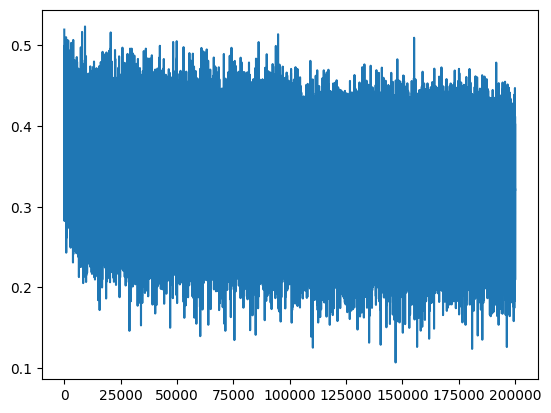

In [13]:
plt.plot(lossi)
plt.show()

### EVALUATION

with torch.no_grad():
    #pass the training set through
    emb = C[X_train]
    embcat= emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire treining set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [15]:
# @torch.no_grade() # this decorator disables gradient tracking

def split_loss(split):
    x,y ={
        'train': (X_train,Y_train),
        'dev' : (X_dev, Y_dev),
        'test' : (X_test,Y_test)
    }[split]
    
    emb = C[x] # embedding 
    embcat= emb.view(emb.shape[0],-1)

    hpreact = embcat @ W1 # + b1
    # hpreact = bngain * (hpreact - hpreact.mean(0,keepdim=True)) / hpreact.std(0,keepdim=True) + bnbias # BatchNorm
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    
    h = torch.tanh(hpreact)  # Hidden Layer 1
    logits = h @ W2 + b2  # Output layer 
    loss = F.cross_entropy(logits, y)  # LOSS
    
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.0664174556732178
dev 2.1113367080688477


### Sample from the model

In [17]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range (20):
    
    out = []
    context = [0] * block_size # initalize with all "..."
    
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1,-1) @ W1 + bnbias)
        logits = h @ W2 + b2 
        prob = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(prob,num_samples=1, generator=g).item()
        context = context[1:] + [ix]

        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mrreng.
hazzier.
mndhryllahn.
mrcceng.
quz.
jazseng.
lilgstynahn.
mitzsonnanar.
kayziqslyna.
nyshuberghangjess.
jazshmil.
qurwhn.
frukumned.
rhyshunzels.
kaysh.
sthlan.
hmandah.
jasuh.
zakhlvennan.
crbvwunnaosh.
